In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/bigdatafed

/content/gdrive/My Drive/Colab Notebooks/bigdatafed


In [0]:
!ls

 baseline.ipynb
'Gold Futures Historical Data_2014.csv'
'Gold Futures Historical Data_2017.csv'
'Gold Futures Historical Data_2019.csv'
'Silver Futures Historical Data_2014.csv'
'Silver Futures Historical Data_2017.csv'
'Silver Futures Historical Data_2019.csv'


In [0]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
df_gold = pd.read_csv('Gold Futures Historical Data_2014.csv')
df_gold.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Apr 26, 2019","1,288.30","1,280.55","1,290.85","1,276.25",-,0.98%
1,"Apr 25, 2019","1,275.80","1,280.60","1,280.80","1,276.40",0.10K,0.02%
2,"Apr 24, 2019","1,275.50","1,268.40","1,273.90","1,267.80",0.52K,0.49%
3,"Apr 23, 2019","1,269.30","1,266.40","1,269.80","1,266.00",0.21K,-0.57%
4,"Apr 22, 2019","1,276.55","1,278.85","1,281.90","1,275.75",-,-0.18%


In [0]:
# check missing value
null_count = pd.DataFrame(df_gold.isnull().sum().sort_values(ascending=False))
null_count

,0
Change %,0
Vol.,0
Low,0
High,0
Open,0
Price,0
Date,0


In [0]:
df_gold.shape

(1406, 7)

In [0]:
# First, we get the data
dataset = pd.read_csv('Gold Futures Historical Data_2014.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-04-26,"1,288.30","1,280.55","1,290.85","1,276.25",-,0.98%
2019-04-25,"1,275.80","1,280.60","1,280.80","1,276.40",0.10K,0.02%
2019-04-24,"1,275.50","1,268.40","1,273.90","1,267.80",0.52K,0.49%
2019-04-23,"1,269.30","1,266.40","1,269.80","1,266.00",0.21K,-0.57%
2019-04-22,"1,276.55","1,278.85","1,281.90","1,275.75",-,-0.18%


In [0]:
# check missing value
null_count = pd.DataFrame(dataset.isnull().sum().sort_values(ascending=False))
null_count

,0
Change %,0
Vol.,0
Low,0
High,0
Open,0
Price,0


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1406 entries, 2019-04-26 to 2014-01-01
Data columns (total 6 columns):
Price       1406 non-null object
Open        1406 non-null object
High        1406 non-null object
Low         1406 non-null object
Vol.        1406 non-null object
Change %    1406 non-null object
dtypes: object(6)
memory usage: 76.9+ KB


In [0]:
# pre-process data
def pre_process(dataframe):
  dataframe['Price'] = (dataframe['Price'].str.replace(',', '')).astype(float)
  dataframe['Open'] = (dataframe['Open'].str.replace(',', '')).astype(float)
  dataframe['High'] = (dataframe['High'].str.replace(',', '')).astype(float)
  dataframe['Low'] = (dataframe['Low'].str.replace(',', '')).astype(float)
  dataframe['Change'] = (dataframe['Change %'].str.replace('%', '')).astype(float)
  dataframe['Vol'] = dataframe['Vol.'].str.replace('K', '')
  dataframe['Vol'] = (dataframe['Vol'].str.replace('-', '0')).astype(float)
  dataframe['Vol'] = dataframe['Vol'].apply(lambda x: x*1000)
  dataframe = dataframe.drop(columns=['Change %', 'Vol.'])
  return dataframe 

df = pre_process(dataset)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1406 entries, 2019-04-26 to 2014-01-01
Data columns (total 6 columns):
Price     1406 non-null float64
Open      1406 non-null float64
High      1406 non-null float64
Low       1406 non-null float64
Change    1406 non-null float64
Vol       1406 non-null float64
dtypes: float64(6)
memory usage: 76.9 KB


In [0]:
df.head()

,Price,Open,High,Low,Change,Vol
Date,,,,,,
2019-04-26,1288.30,1280.55,1290.85,1276.25,0.98,0.0
2019-04-25,1275.80,1280.60,1280.80,1276.40,0.02,100.0
2019-04-24,1275.50,1268.40,1273.90,1267.80,0.49,520.0
2019-04-23,1269.30,1266.40,1269.80,1266.00,-0.57,210.0
2019-04-22,1276.55,1278.85,1281.90,1275.75,-0.18,0.0


In [0]:
df.describe()

,Price,Open,High,Low,Change,Vol
count,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000,1406.000000
mean,1248.170427,1248.165982,1253.404360,1242.942909,0.009836,8488.748222
std,71.205546,71.073546,70.590872,71.621866,0.986354,40014.700811
min,1050.800000,1053.700000,1062.000000,1046.200000,-3.610000,0.000000
25%,1207.125000,1206.200000,1212.325000,1201.375000,-0.440000,30.000000
50%,1253.850000,1254.400000,1259.150000,1249.850000,-0.010000,140.000000
75%,1299.525000,1298.875000,1304.000000,1293.775000,0.447500,520.000000
max,1402.200000,1401.100000,1404.400000,1393.300000,4.660000,370400.000000


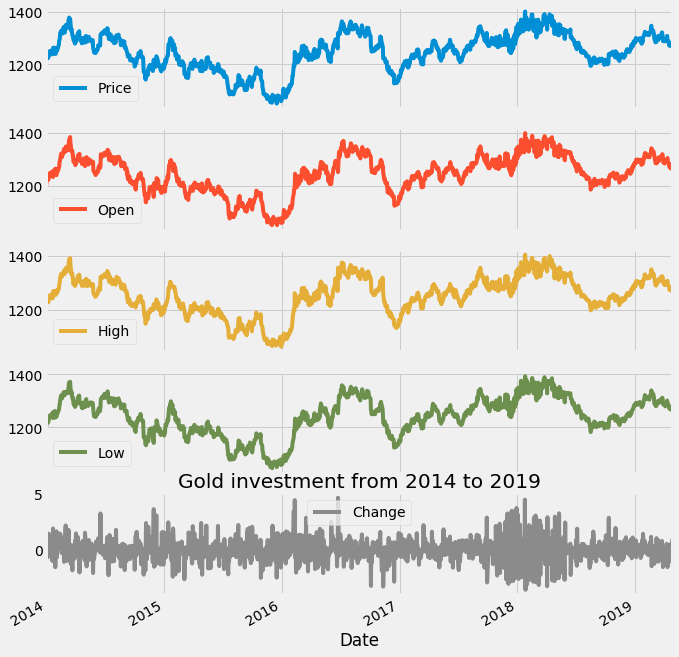

In [0]:
df[['Price', 'Open', 'High', 'Low', 'Change']].plot(subplots=True, figsize=(10,12))
plt.title('Gold investment from 2014 to 2019')
plt.savefig('Gold_investment.png')
plt.show()

In [0]:
df_day = df.resample('d').mean()
df_month = df.resample('m').mean()

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series



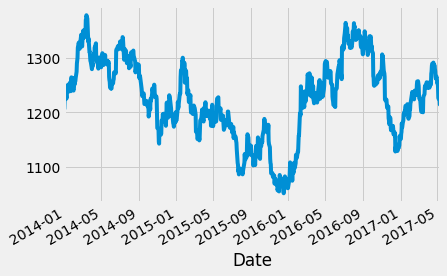

In [0]:

https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorialdf['Price']['2017-05-10':].plot()

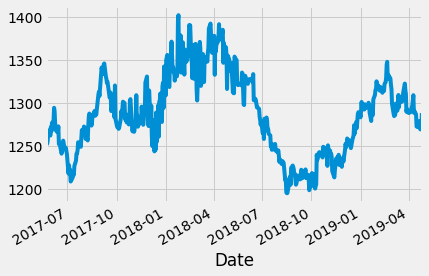

In [0]:
df['Price'][:'2017-05-22'].plot()

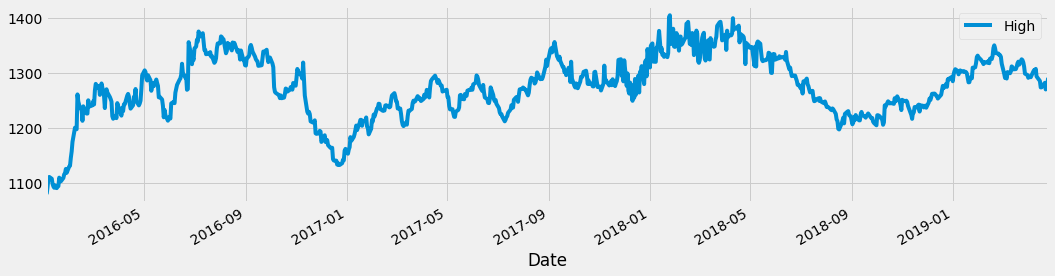

In [0]:
df["High"][:'2016'].plot(figsize=(16,4),legend=True)

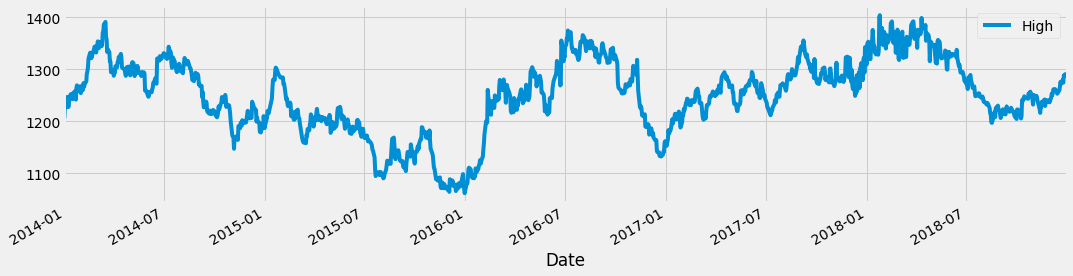

In [0]:
df["High"]['2018':].plot(figsize=(16,4),legend=True)

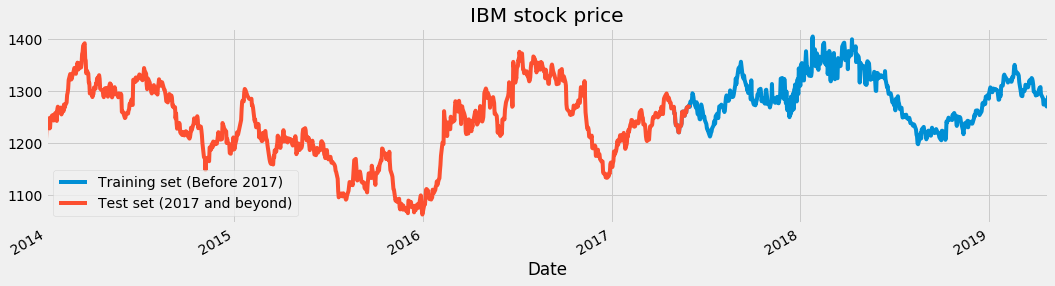

In [0]:
dataset["High"][:'2017-05'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017-05':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [0]:
dataset =  df

In [0]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [0]:
dataset[:'2016'].iloc[:,1:2].head()

,Open
Date,
2019-04-26,1280.55
2019-04-25,1280.60
2019-04-24,1268.40
2019-04-23,1266.40
2019-04-22,1278.85


In [0]:
print(dataset.shape[0],len(test_set), len(training_set))

1406 1055 880


In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
len(dataset["High"][:'2016'])

880

In [0]:

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,880):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train

array([[0.64302635, 0.64317442, 0.60704768, ..., 0.74296713, 0.73289902,
        0.75806929],
       [0.64317442, 0.60704768, 0.60112526, ..., 0.73289902, 0.75806929,
        0.75037015],
       [0.60704768, 0.60112526, 0.6379923 , ..., 0.75806929, 0.75037015,
        0.76754516],
       ...,
       [0.43855493, 0.45395321, 0.44655019, ..., 0.12525911, 0.14124963,
        0.08350607],
       [0.45395321, 0.44655019, 0.54575067, ..., 0.14124963, 0.08350607,
        0.05389399],
       [0.44655019, 0.54575067, 0.5347942 , ..., 0.08350607, 0.05389399,
        0.03612674]])

In [0]:

len(X_train)

820

In [0]:

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:

X_train.shape[0]

820

In [0]:
Sequential()

In [0]:

# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

# need train 50 epoch

Epoch 1/10
820/820 [==============================] - 8s 10ms/step - loss: 0.0502
Epoch 2/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0236
Epoch 3/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0228
Epoch 4/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0177
Epoch 5/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0165
Epoch 6/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0158
Epoch 7/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0145
Epoch 8/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0127
Epoch 9/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0137
Epoch 10/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0114


In [0]:

# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["Open"][:'2016'],dataset["Open"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
# this one respond 311
len(dataset_total[len(dataset_total)-len(test_set) - 60:])

1115

In [0]:

len(dataset_total)-len(test_set) - 60

820

In [0]:

len(dataset_total)

1935

In [0]:

len(dataset)

1406

In [0]:

len(dataset_total)-len(test_set) - 60

820

In [0]:
inputs=dataset_total[len(dataset_total)-len(test_set) - 60:].values

In [0]:

#inputs

array([1247.7, 1244. , 1256.2, ..., 1221.7, 1204.3, 1203.6])

In [0]:
#inputs.reshape(-1,1)

array([[1247.7],
       [1244. ],
       [1256.2],
       ...,
       [1221.7],
       [1204.3],
       [1203.6]])

In [0]:

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [0]:

# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

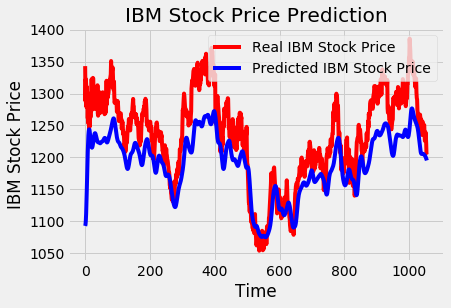

In [0]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [0]:
import math 
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is: {}".format(rmse))

The root mean squared error is: 53.1761678892585


In [0]:

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
820/820 [==============================] - 8s 10ms/step - loss: 0.0365
Epoch 2/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0139
Epoch 3/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0156
Epoch 4/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0118
Epoch 5/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0146
Epoch 6/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0130
Epoch 7/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0116
Epoch 8/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0098
Epoch 9/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0103
Epoch 10/10
820/820 [==============================] - 3s 4ms/step - loss: 0.0089


In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [0]:
#GRU_predicted_stock_price = regressorGRU.predict(X_test)
#GRU_predicted_stock_price

In [0]:
#len(GRU_predicted_stock_price)

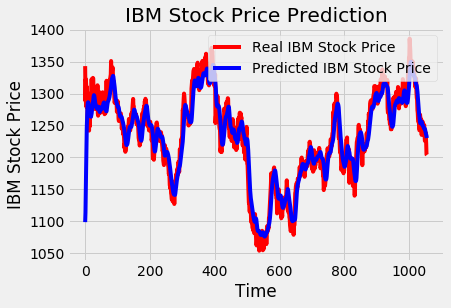

In [0]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [0]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 22.14308092318906.


In [0]:
regressorBi = Sequential()
# First LSTM layer with Dropout regularisation
regressorBi.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],1), merge_mode='concat'))
regressorBi.add(Dropout(0.2))

# Second LSTM layer
regressorBi.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBi.add(Dropout(0.2))

# Third LSTM layer
regressorBi.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBi.add(Dropout(0.2))

# Fourth LSTM layer
regressorBi.add(Bidirectional(LSTM(units=50)))
regressorBi.add(Dropout(0.2))

# The output layer
regressorBi.add(Dense(units=1))

# Compiling the RNN
regressorBi.compile(optimizer='rmsprop',loss='mean_squared_error') # try optimizer='adam'

# fitting to the training set
regressorBi.fit(X_train,y_train,epochs=10,batch_size=32)


#regressorBi.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_valid,y_valid),callbacks=[early_stopping, saveBestModel])

Epoch 1/10
820/820 [==============================] - 21s 26ms/step - loss: 0.0579
Epoch 2/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0242
Epoch 3/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0215
Epoch 4/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 5/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0155
Epoch 6/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0133
Epoch 7/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0106
Epoch 8/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0111
Epoch 9/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0100
Epoch 10/10
820/820 [==============================] - 9s 11ms/step - loss: 0.0093


In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Bi_predicted_stock_price = regressor # prepare X_test and predicting the prices

X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  
Bi_predicted_stock_price = regressorBi.predict(X_test) 
Bi_predicted_stock_price = sc.inverse_transform(Bi_predicted_stock_price)


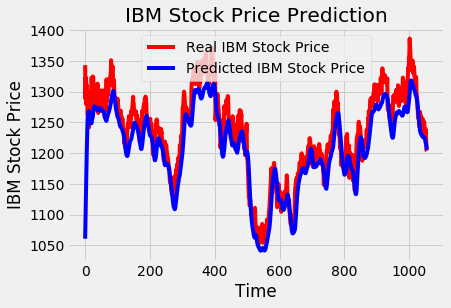

In [0]:
# Visualizing the results for GRU
plot_predictions(test_set,Bi_predicted_stock_price)

In [0]:
# Evaluating GRU
return_rmse(test_set,Bi_predicted_stock_price)

The root mean squared error is 32.41683324927911.


**GRU+1 layer LSTM**

In [0]:

# The GRU architecture
regressorGL = Sequential()
# First GRU layer with Dropout regularisation
regressorGL.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGL.add(Dropout(0.2))
# Second GRU layer
regressorGL.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGL.add(Dropout(0.2))

# Third GRU layer
regressorGL.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGL.add(Dropout(0.2))

# Fourth GRU layer
regressorGL.add(LSTM(units=50))
regressorGL.add(Dropout(0.2))
# The output layer
regressorGL.add(Dense(units=1))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGL.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
regressorGL.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
820/820 [==============================] - 13s 16ms/step - loss: 0.0412
Epoch 2/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0151
Epoch 3/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0181
Epoch 4/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0142
Epoch 5/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0133
Epoch 6/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0121
Epoch 7/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0120
Epoch 8/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0104
Epoch 9/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0107
Epoch 10/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0100


In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GL1_predicted_stock_price = regressorGL.predict(X_test)
GL1_predicted_stock_price = sc.inverse_transform(GL1_predicted_stock_price)

In [0]:

return_rmse(test_set,GL1_predicted_stock_price)

The root mean squared error is 24.578711073483124.


**GRU+2 layer LSTM**

In [0]:

# The GRU architecture
regressorGL2 = Sequential()
# First GRU layer with Dropout regularisation
regressorGL2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGL2.add(Dropout(0.2))
# Second GRU layer
regressorGL2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGL2.add(Dropout(0.2))

# Third GRU layer
regressorGL2.add(LSTM(units=50, return_sequences=True))
regressorGL2.add(Dropout(0.2))

# Fourth GRU layer
regressorGL2.add(LSTM(units=50))
regressorGL2.add(Dropout(0.2))
# The output layer
regressorGL2.add(Dense(units=1))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGL2.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
regressorGL2.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
820/820 [==============================] - 14s 17ms/step - loss: 0.0559
Epoch 2/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0187
Epoch 3/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0193
Epoch 4/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0156
Epoch 5/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0151
Epoch 6/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0141
Epoch 7/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0138
Epoch 8/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0128
Epoch 9/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0111
Epoch 10/10
820/820 [==============================] - 4s 5ms/step - loss: 0.0110


In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GL2_predicted_stock_price = regressorGL2.predict(X_test)
GL2_predicted_stock_price = sc.inverse_transform(GL2_predicted_stock_price)

In [0]:

return_rmse(test_set,GL2_predicted_stock_price)

The root mean squared error is 42.8036407516309.


** 2 layer LSTM + 2 layer GRU**

In [0]:

# The LSTM architecture
regressor_2L2G = Sequential()
# First LSTM layer with Dropout regularisation
regressor_2L2G.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor_2L2G.add(Dropout(0.2))

# Second LSTM layer
regressor_2L2G.add(LSTM(units=50, return_sequences=True))
regressor_2L2G.add(Dropout(0.2))


# Third LSTM layer
regressor_2L2G.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressor_2L2G.add(Dropout(0.2))

# Fourth LSTM layer
regressor_2L2G.add(GRU(units=50, activation='tanh'))
regressor_2L2G.add(Dropout(0.2))



# The output layer
regressor_2L2G.add(Dense(units=1))

# Compiling the RNN
regressor_2L2G.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_2L2G.fit(X_train,y_train,epochs=10,batch_size=32)

In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
L2G2_predicted_stock_price = regressor_2L2G.predict(X_test)
L2G2_predicted_stock_price = sc.inverse_transform(L2G2_predicted_stock_price)

return_rmse(test_set, L2G2_predicted_stock_price)

The root mean squared error is 26.5215622927566.


** 1 layer LSTM + 3 GRU**

In [0]:

# The LSTM architecture
regressor_L1G3 = Sequential()
# First LSTM layer with Dropout regularisation
regressor_L1G3.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor_L1G3.add(Dropout(0.2))

# Second LSTM layer
regressor_L1G3.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressor_L1G3.add(Dropout(0.2))


# Third LSTM layer
regressor_L1G3.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressor_L1G3.add(Dropout(0.2))

# Fourth LSTM layer
regressor_L1G3.add(GRU(units=50, activation='tanh'))
regressor_L1G3.add(Dropout(0.2))



# The output layer
regressor_L1G3.add(Dense(units=1))

# Compiling the RNN
regressor_L1G3.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor_L1G3.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
820/820 [==============================] - 15s 19ms/step - loss: 0.0484
Epoch 2/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0211
Epoch 3/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0158
Epoch 4/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0162
Epoch 5/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0137
Epoch 6/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0129
Epoch 7/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0124
Epoch 8/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0131
Epoch 9/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0097
Epoch 10/10
820/820 [==============================] - 4s 4ms/step - loss: 0.0112


In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,1115):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
L1G3_predicted_stock_price = regressor_L1G3.predict(X_test)
L1G3_predicted_stock_price = sc.inverse_transform(L1G3_predicted_stock_price)

return_rmse(test_set, L2G2_predicted_stock_price)

The root mean squared error is 26.5215622927566.


In [0]:
c = Bi_predicted_stock_price.flatten()
c.shape

(63300,)

In [0]:
   a = np.squeeze(Bi_predicted_stock_price.shape, axis=(2,))


In [0]:
a.shape


(3,)

In [0]:
b = np.squeeze(Bi_predicted_stock_price.shape, axis=(1,))
b.shape

(3,)

In [0]:
len(Bi_predicted_stock_price)

In [0]:
Bi_predicted_stock_price

array([[[ 0.00240054],
        [-0.00164628],
        [-0.00503088],
        ...,
        [-0.00051397],
        [-0.0001286 ],
        [ 0.00026349]],

       [[ 0.00235875],
        [-0.00169017],
        [-0.00506952],
        ...,
        [-0.00197   ],
        [-0.00154854],
        [-0.00090088]],

       [[ 0.00230595],
        [-0.00173527],
        [-0.00511313],
        ...,
        [-0.00366157],
        [-0.00312141],
        [-0.00195824]],

       ...,

       [[ 0.00389986],
        [-0.00222985],
        [-0.00747616],
        ...,
        [-0.00780501],
        [-0.00511922],
        [-0.00206749]],

       [[ 0.00375191],
        [-0.00252831],
        [-0.00788295],
        ...,
        [-0.00770198],
        [-0.00503808],
        [-0.00201783]],

       [[ 0.00357403],
        [-0.00282707],
        [-0.00827252],
        ...,
        [-0.00747583],
        [-0.00484248],
        [-0.00188664]]], dtype=float32)

In [0]:
Bi_predicted_stock_price = sc.inverse_transform(Bi_predicted_stock_price)

In [0]:
Bi_predicted_stock_price = sc.inverse_transform(Bi_predicted_stock_price)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

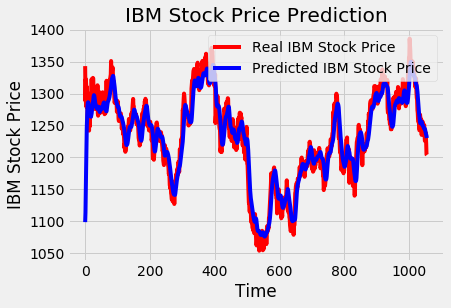

In [0]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [0]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 22.14308092318906.


In [0]:
regressorB1 = Sequential()

In [0]:
regressorB1.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1) merge_mode='concat'))

In [0]:
regressorGRU = Sequential()
regressorGRU.add(GRU(unit=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

In [0]:
def dynamic_plot(df, start_date, end_date):
  df['Price'][start_date: end_date].plot(figsize=(16,4),legend=True
  plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
  plt.title('IBM stock price')
  plt.show()

SyntaxError: ignored

In [0]:
# Checking for missing values
training_set = dataset[:'2017'].iloc[:,1:2].values
test_set = dataset['2018':].iloc[:,1:2].values

In [0]:
len(training_set), len(test_set)

(615, 1319)

In [0]:
dataset.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [0]:
#dataset['Price1'] = dataset['Price'].apply(lambda x: x.replace(',' ''))
dataset['Price2'] = (dataset['Price'].str.replace(',', '')).astype(float)

In [0]:
dataset['Price1'] = dataset['Price1'].astype(float)

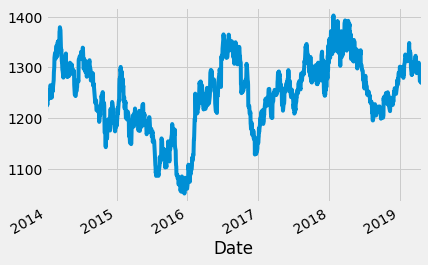

In [0]:
dataset['Price2'].plot()

In [0]:
dataset['Price2'] = dataset['Price'].apply(lambda x: x.strip(','))
dataset['Price2'] = dataset['Price2'].astype(float)

In [0]:

# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2017'].plot(figsize=(16,4),legend=True)
dataset["High"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()